In [1]:
import pandas as pd
import datetime as dt
import pandas_datareader.data as web

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import os
from tqdm import tqdm


In [2]:
class stockPred:
    def __init__(self,starting_date):
        self.df = pd.DataFrame()
        self.start = dt.datetime.strptime(starting_date, "%d/%m/%y")

    
    def stockAdd(self,stock):
        self.df_aux = pd.DataFrame()
        self.df_aux = web.DataReader(stock, 'yahoo', self.start)
        nome_coluna = []
        for x in self.df_aux.columns:
            nome_coluna.append(str(stock)+'_'+str(x))
        self.df_aux.columns=nome_coluna
        self.df = pd.concat([self.df, self.df_aux], axis=1)
        return self.df
    
    
    def predDays(self,stock,days):
        self.days = days
        self.stock = stock
        self.df_pred = self.df.copy()
        self.df_pred[str(stock)+'_shift'+str(days)] = self.df_pred[str(stock)+'_Adj Close'].shift(-days)
        self.df_dropna = self.df_pred.dropna(inplace=False)
        return self.df_pred, self.df_dropna
    
    def trainTest(self):
        self.X_dropna = self.df_dropna.drop([str(self.stock)+'_shift'+str(self.days)], 1)
        self.X = self.df_pred.drop([str(self.stock)+'_shift'+str(self.days)], 1)
        self.Y_dropna = self.df_dropna[str(self.stock)+'_shift'+str(self.days)]
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X_dropna, self.Y_dropna, test_size=0.8)
        return self.X_dropna, self.X
    
    def date_by_adding_business_days(self):
        business_days_to_add = self.days
        current_date = self.base_date
        while business_days_to_add > 0:
            current_date += dt.timedelta(days=1)
            weekday = current_date.weekday()
            if weekday >= 5: # sunday = 6
                continue
            business_days_to_add -= 1
        return current_date

        
    def trainModel(self,base_date,verbose = 0):
        self.base_date = dt.datetime.strptime(base_date, "%d/%m/%y")
        self.clf = RandomForestRegressor(max_depth=100, random_state=0,n_estimators=300, n_jobs = -1)
        self.clf.fit(self.X_train, self.Y_train)
        #print(self.X.tail())
        self.prediction = (self.clf.predict(self.X.loc[self.base_date:self.base_date]))
        self.pred_day = self.date_by_adding_business_days()
        if verbose == 1:
            print('Score train {}'.format(self.clf.score(self.X_train,self.Y_train)))
            print('Score test {}'.format(self.clf.score(self.X_test,self.Y_test)))
            print('Score full {}'.format(self.clf.score(self.X_dropna,self.Y_dropna)))
        return self.clf, self.prediction, self.pred_day
        
        

In [3]:
#Stating the class, setting starting date, building db

x = stockPred('01/01/19')
y = x.stockAdd('JBSS3.SA')
#y = x.stockAdd('^BVSP')



In [79]:
#predicting stock pricing for the next N days

x = stockPred('01/01/18')
y = x.stockAdd('JBSS3.SA')
#y = x.stockAdd('^BVSP')

pred_list = []
day_list = []
for i in tqdm(range(1,20)):
    x.predDays('JBSS3.SA',i)
    x.trainTest()
    a,pred,dia = x.trainModel('10/09/19',verbose =0)
    pred_list.append(round(pred[0],2))
    day_list.append(dia)
    
for a,b in zip(day_list,pred_list):
    print('Data:{0} - Valor {1:.2f}'.format(a.strftime('%d/%m/%y'),b))
    
y['Data'] = y.index

df_pred = pd.DataFrame(data=pred_list,index=day_list,columns=['Pred'])
df_pred['Data'] = df_pred.index

result = pd.merge(y,df_pred[['Pred','Data']], on= 'Data' , how='outer')

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.97it/s]


Data:11/09/19 - Valor 28.74
Data:12/09/19 - Valor 29.34
Data:13/09/19 - Valor 29.58
Data:16/09/19 - Valor 29.14
Data:17/09/19 - Valor 29.38
Data:18/09/19 - Valor 29.31
Data:19/09/19 - Valor 29.52
Data:20/09/19 - Valor 28.81
Data:23/09/19 - Valor 28.77
Data:24/09/19 - Valor 28.89
Data:25/09/19 - Valor 29.33
Data:26/09/19 - Valor 29.71
Data:27/09/19 - Valor 29.87
Data:30/09/19 - Valor 29.46
Data:01/10/19 - Valor 29.56
Data:02/10/19 - Valor 29.62
Data:03/10/19 - Valor 29.78
Data:04/10/19 - Valor 29.77
Data:07/10/19 - Valor 29.38


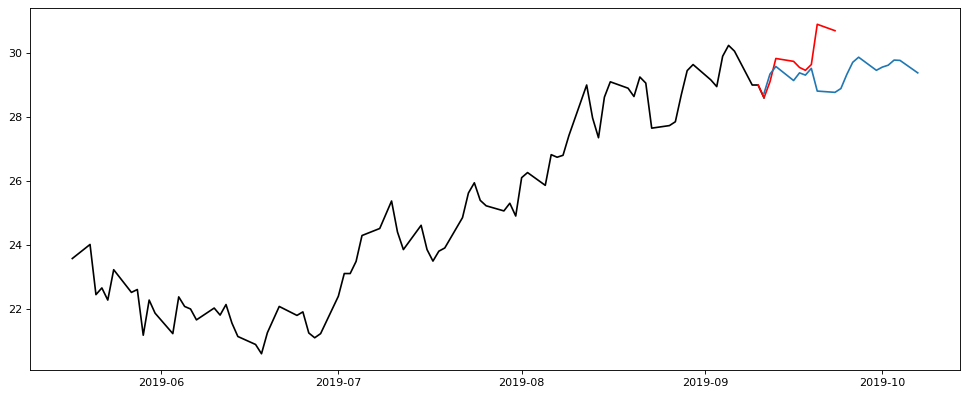

In [86]:
last_x_days = 20
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(result['Data'].iloc[-last_x_days*5:-last_x_days+2], result['JBSS3.SA_Adj Close'].iloc[-last_x_days*5:-last_x_days+2], color = 'black')
plt.plot(result['Data'].iloc[-last_x_days:], result['JBSS3.SA_Adj Close'].iloc[-last_x_days:], color = 'red')
plt.plot(result['Data'].iloc[-last_x_days:], result['Pred'].iloc[-last_x_days:])
plt.show()